<div>
    <h1 style="text-align:center;"> <b>FLO</b> Gözetimsiz Öğrenme <br></h1>
</div>

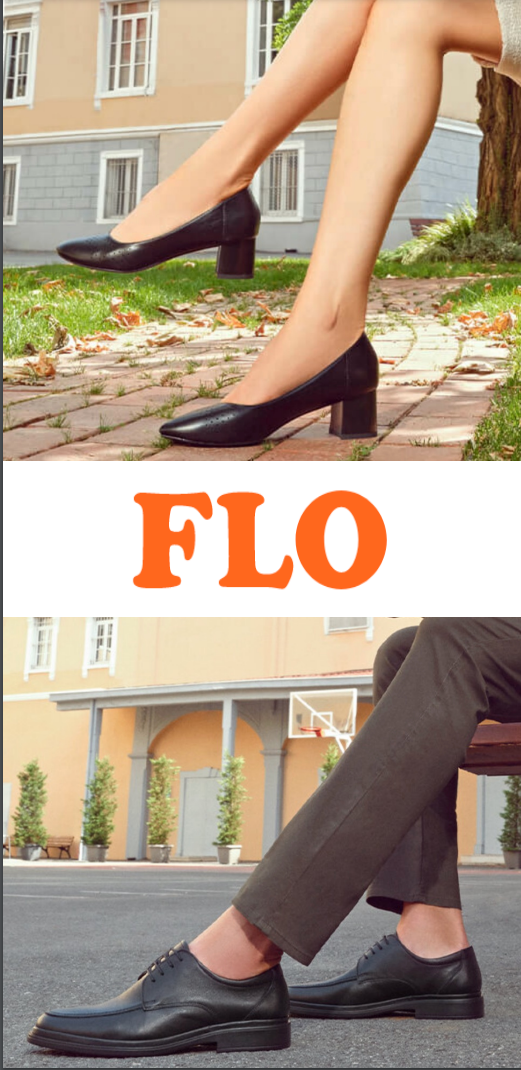

<h1 style="text-align:left;" fontsize:35> İş Problemi</h1>
    <hr>
    <h3 style="text-align:left;" fontsize:20> Online ayakkabı mağazası olan FLO müşterilerini
segmentlere ayırıp bu segmentlere göre pazarlama
stratejileri belirlemek istiyor. <br> Buna yönelik olarak
müşterilerin davranışları tanımlanacak ve bu
davranışlardaki öbeklenmelere göre gruplar oluşturulacak.</h3>

<h1 style="text-align:left;" fontsize:35>Değişkenler</h1>
    <hr>


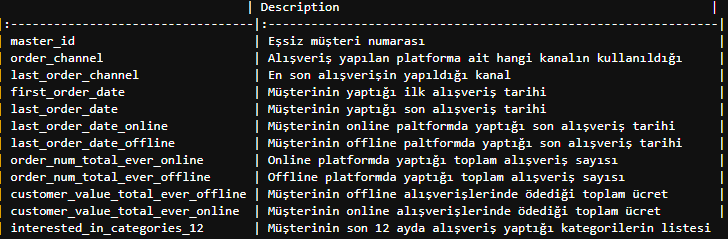

In [1]:
import pandas as pd
import datetime as dt
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", "#beb9db", "#fdcce5", "#8bd3c7"]
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)

In [2]:
df = pd.read_csv("flo_data_20k.csv")
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR]


# EDA

In [3]:
def check_df(dataframe, head=5, tail=5):
    print("*" * 70)
    print(" Shape ".center(70, "*"))
    print("*" * 70)
    print(dataframe.shape)

    print("*" * 70)
    print(" Types ".center(70, "*"))
    print("*" * 70)
    print(dataframe.dtypes)

    print("*" * 70)
    print(" Head ".center(70, "*"))
    print("*" * 70)
    print(dataframe.head(head))

    print("*" * 70)
    print(" Tail ".center(70, "*"))
    print("*" * 70)
    print(dataframe.tail(tail))

    print("*" * 70)
    print(" NA ".center(70, "*"))
    print("*" * 70)
    print(dataframe.isnull().sum())

    print("*" * 70)
    print(" Quantiles ".center(70, "*"))
    print("*" * 70)
    print(dataframe.describe([.01, .05, .1, .5, .9, .95, .99]).T)

    print("*" * 70)
    print(" Uniques ".center(70, "*"))
    print("*" * 70)
    print(dataframe.nunique())
    
check_df(df)

**********************************************************************
******************************* Shape ********************************
**********************************************************************
(19945, 12)
**********************************************************************
******************************* Types ********************************
**********************************************************************
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
dtype: object
********

1. Tarih değişkenleri object olarak tanımlanmış. Tarih tipine değiştirilmesi gerekir.
2. Veri setinde boş gözlem yok.
3. Online alışveriş sayısı daha fazla
4. Tüm müşteriler en az 1'er kere hem online hemde offline alışveriş yapmış
8. Veri seti gruplanmış. Bu yüzden yapılacak hesaplamalarda tekrardan bir gruplama yapılmasına gerek yok.

In [4]:
df["new_total_expenditure"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]
df["new_total_purchases"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]

print(
    f'{df["new_total_purchases"].sum()} invoices were carried out from {df["first_order_date"].min()} to'
    f' {df["last_order_date"].max()}')

print(
    f'{df["master_id"].nunique()} customer were served from {df["first_order_date"].min()} to '
    f'{df["last_order_date"].max()}')

100219.0 invoices were carried out from 2013-01-14 to 2021-05-30
19945 customer were served from 2013-01-14 to 2021-05-30


In [5]:
date_vars = df.columns[df.columns.str.contains("date")]

for col in date_vars:
    df[col] = pd.to_datetime(df[col])

####################################################################################################
Android App    9495
Mobile         4882
Ios App        2833
Desktop        2735
Name: order_channel, dtype: int64


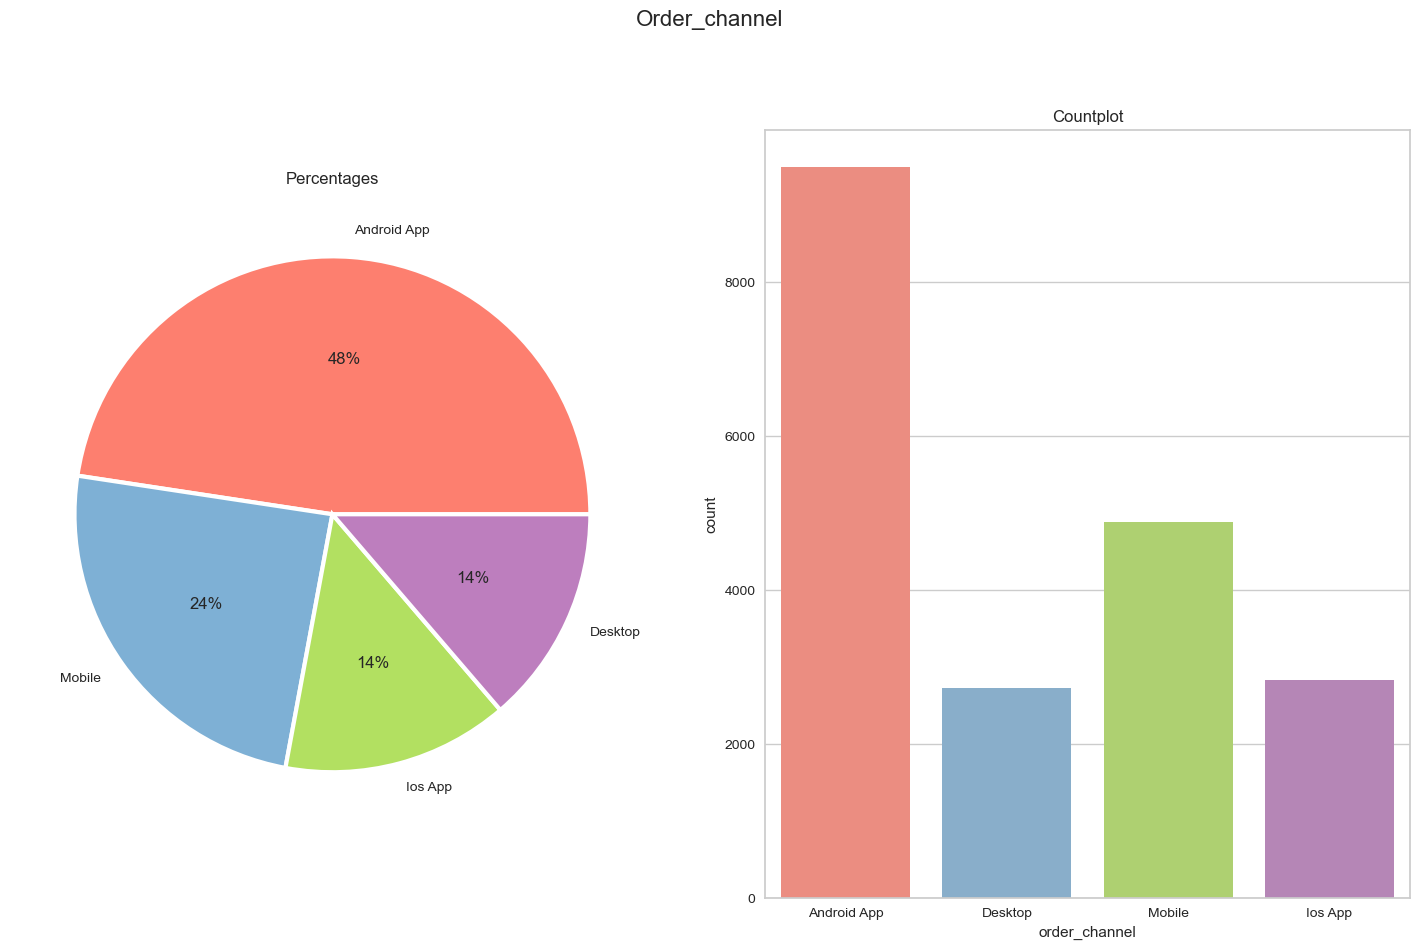

In [6]:
def cat_plots(dataframe, cat_col):
    print("".center(100, "#"))
    print(dataframe[cat_col].value_counts())

    plt.figure(figsize=(15, 10))
    plt.suptitle(cat_col.capitalize(), size=16)
    plt.subplot(1, 2, 1)
    plt.title("Percentages")
    plt.pie(dataframe[cat_col].value_counts().values.tolist(),
            labels=dataframe[cat_col].value_counts().keys().tolist(),
            labeldistance=1.1,
            wedgeprops={'linewidth': 3, 'edgecolor': 'white'},
            colors=colors,
            autopct='%1.0f%%')

    plt.subplot(1, 2, 2)
    plt.title("Countplot")
    sns.countplot(data=dataframe, x=cat_col, palette=colors)
    plt.tight_layout(pad=3)
    plt.show(block=True)
    
cat_plots(df, "order_channel")

                count        mean          std    min        1%        5%      10%      50%       90%       95%        99%       max
order_channel                                                                                                                       
Android App    9495.0  823.492655   974.764418  55.98  120.9406  189.9700  240.868  601.940  1587.146  2114.015  3774.3788  45905.10
Desktop        2735.0  588.782984   636.342300  44.98  110.8634  161.4070  200.964  447.950  1055.678  1369.761  2722.6188  18443.57
Ios App        2833.0  891.634285  1200.294744  69.98  117.9400  210.4660  265.978  642.480  1653.202  2292.428  4499.4120  33918.10
Mobile         4882.0  620.275125   558.159747  44.98   99.9800  156.9935  200.720  469.305  1176.019  1558.663  2663.0472  12726.10


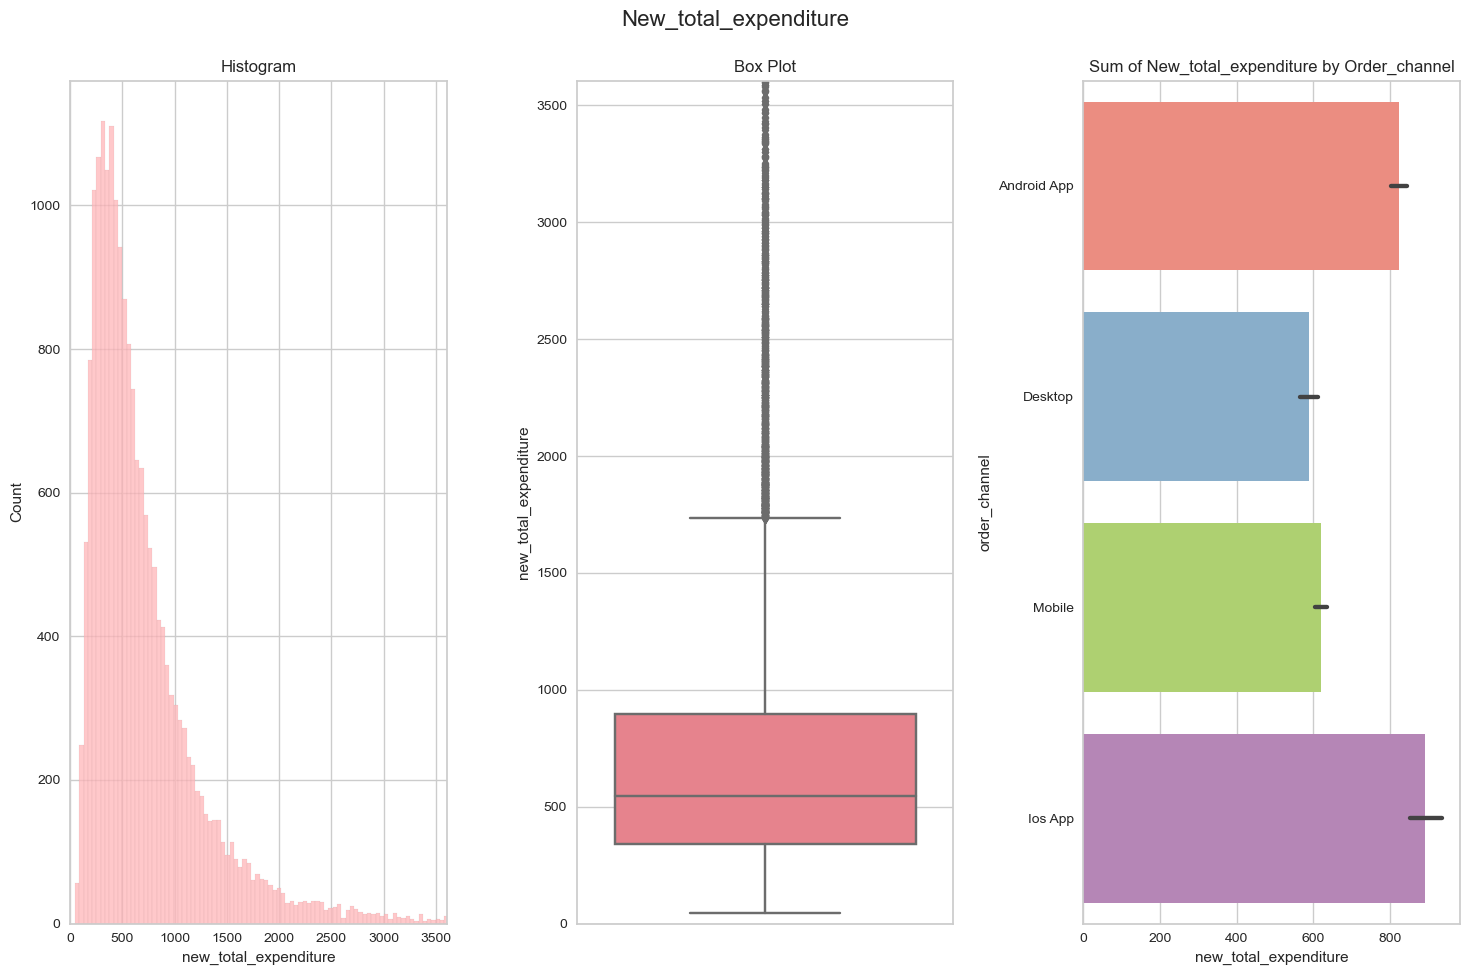

                count      mean       std  min   1%   5%  10%  50%   90%   95%    99%    max
order_channel                                                                               
Android App    9495.0  5.504897  5.245134  2.0  2.0  2.0  2.0  4.0  10.0  13.0  24.00  202.0
Desktop        2735.0  3.992687  3.206719  2.0  2.0  2.0  2.0  3.0   7.0   9.0  16.00   70.0
Ios App        2833.0  5.418637  5.246047  2.0  2.0  2.0  2.0  4.0   9.0  13.0  25.68   83.0
Mobile         4882.0  4.440598  3.897669  2.0  2.0  2.0  2.0  3.0   8.0  11.0  20.00   77.0


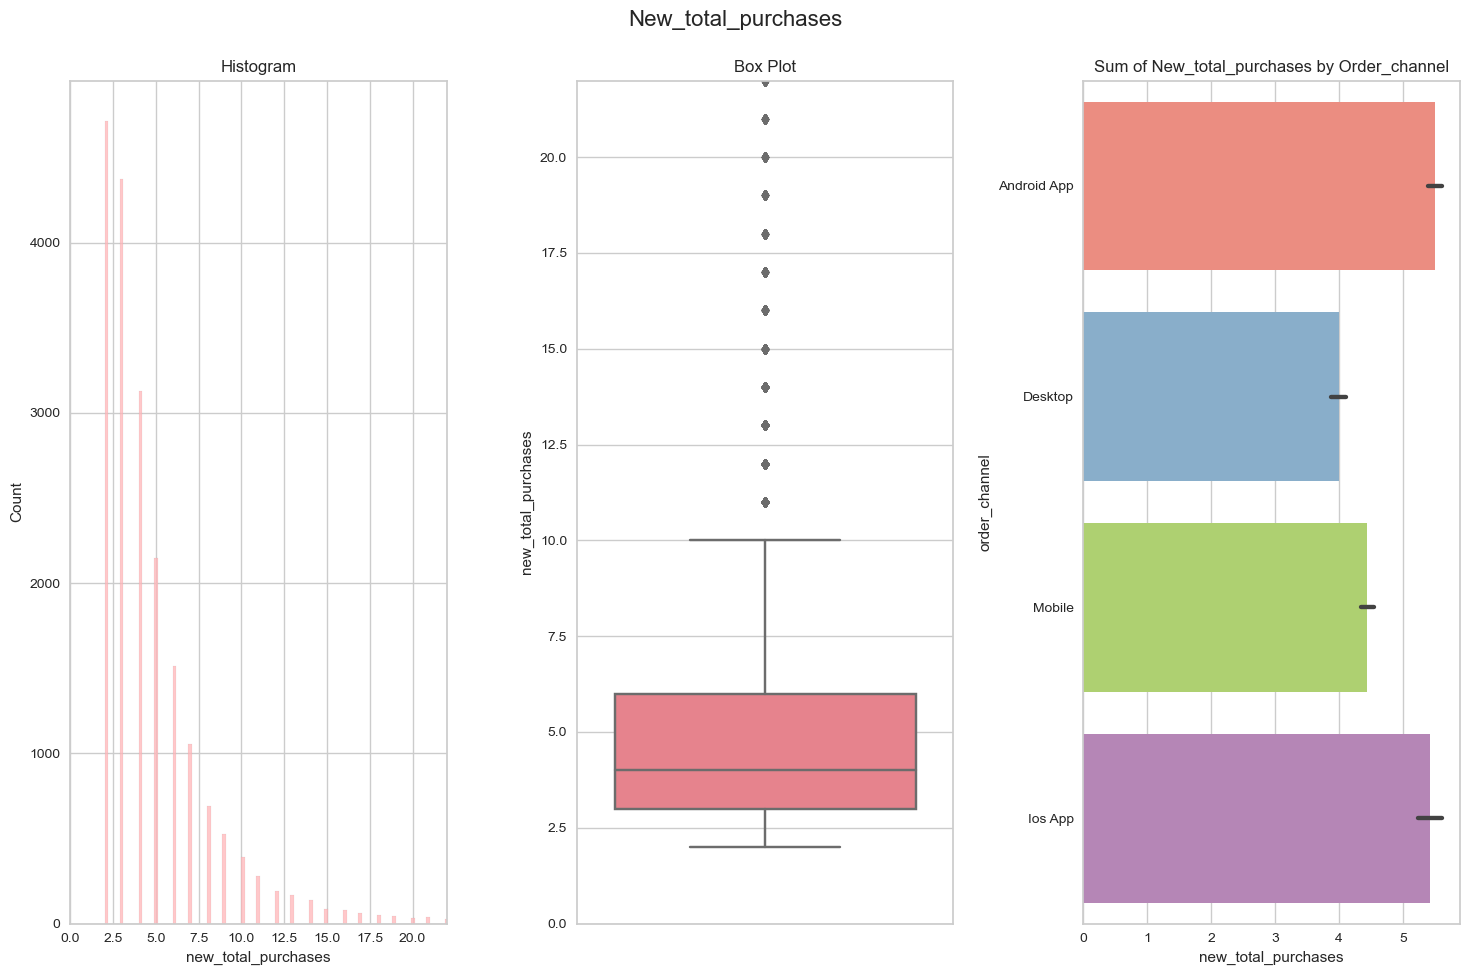

In [7]:
def num_summary(dataframe, col_name, target):
    quantiles = [.01, .05, .1, .5, .9, .95, .99]
    print(dataframe.groupby(target)[col_name].describe(percentiles=quantiles))
    xlim = dataframe[col_name].describe(quantiles).T["99%"]

    plt.figure(figsize=(15, 10))
    plt.suptitle(col_name.capitalize(), size=16)
    plt.subplot(1, 3, 1)
    plt.title("Histogram")
    sns.histplot(dataframe[col_name], color="#FFB6B9")
    plt.xlim(0, xlim)

    plt.subplot(1, 3, 2)
    plt.title("Box Plot")
    sns.boxplot(data=dataframe, y=col_name, color="#F67280")
    plt.ylim(0, xlim)

    plt.subplot(1, 3, 3)
    sns.barplot(data=dataframe, x=col_name, y=target, palette=colors, estimator=np.mean)
    plt.title(f"Sum of {col_name.capitalize()} by {target.capitalize()}")
    plt.tight_layout(pad=1.5)
    plt.show(block=True)
    
for col in df.columns[df.columns.str.contains("new")]:
    num_summary(df, col, "order_channel")

In [8]:
df[["master_id", "new_total_expenditure", "new_total_purchases"]].sort_values("new_total_expenditure",
                                                                              ascending=False).head(10)

,master_id,new_total_expenditure,new_total_purchases
11150,5d1c466a-9cfd-11e9-9897-000d3a38a36f,45905.10,202.0
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,36818.29,68.0
7613,73fd19aa-9e37-11e9-9897-000d3a38a36f,33918.10,82.0
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,31227.41,11.0
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,20706.34,4.0
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,18443.57,70.0
8068,d696c654-2633-11ea-8e1c-000d3a38a36f,16918.57,70.0
163,fef57ffa-aae6-11e9-a2fc-000d3a38a36f,12726.10,37.0
7223,cba59206-9dd1-11e9-9897-000d3a38a36f,12282.24,131.0
18767,fc0ce7a4-9d87-11e9-9897-000d3a38a36f,12103.15,20.0


In [9]:
df[["master_id", "new_total_expenditure", "new_total_purchases"]].sort_values("new_total_purchases",
                                                                              ascending=False).head(10)

,master_id,new_total_expenditure,new_total_purchases
11150,5d1c466a-9cfd-11e9-9897-000d3a38a36f,45905.10,202.0
7223,cba59206-9dd1-11e9-9897-000d3a38a36f,12282.24,131.0
8783,a57f4302-b1a8-11e9-89fa-000d3a38a36f,10383.44,111.0
2619,fdbe8304-a7ab-11e9-a2fc-000d3a38a36f,8572.23,88.0
6322,329968c6-a0e2-11e9-a2fc-000d3a38a36f,4240.36,83.0
7613,73fd19aa-9e37-11e9-9897-000d3a38a36f,33918.10,82.0
9347,44d032ee-a0d4-11e9-a2fc-000d3a38a36f,5184.05,77.0
10954,b27e241a-a901-11e9-a2fc-000d3a38a36f,5297.88,75.0
8068,d696c654-2633-11ea-8e1c-000d3a38a36f,16918.57,70.0
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,18443.57,70.0


In [10]:
df["first_order_year"] = df["first_order_date"].dt.year
df["first_order_month"] = df["first_order_date"].dt.month_name()
df["first_order_day"] = df["first_order_date"].dt.day_name()

df["last_order_year"] = df["last_order_date"].dt.year
df["last_order_month"] = df["last_order_date"].dt.month_name()
df["last_order_day"] = df["last_order_date"].dt.day_name()

####################################################################################################
2019    10352
2020     4412
2018     1630
2017     1160
2016      662
2015      614
2021      581
2014      405
2013      129
Name: first_order_year, dtype: int64


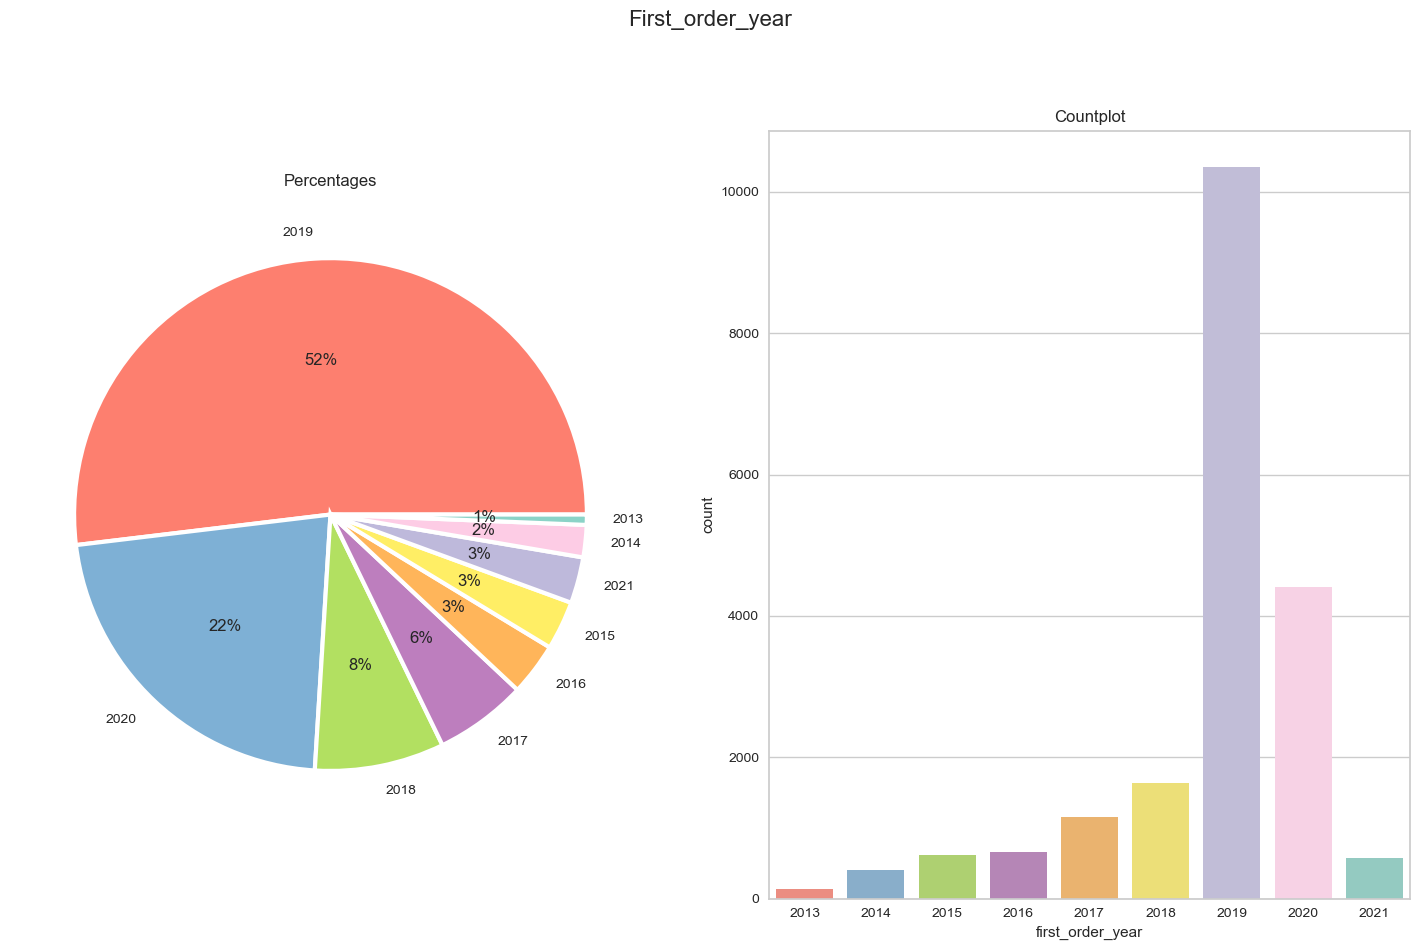

In [11]:
cat_plots(df, "first_order_year")

####################################################################################################
2021    12270
2020     7675
Name: last_order_year, dtype: int64


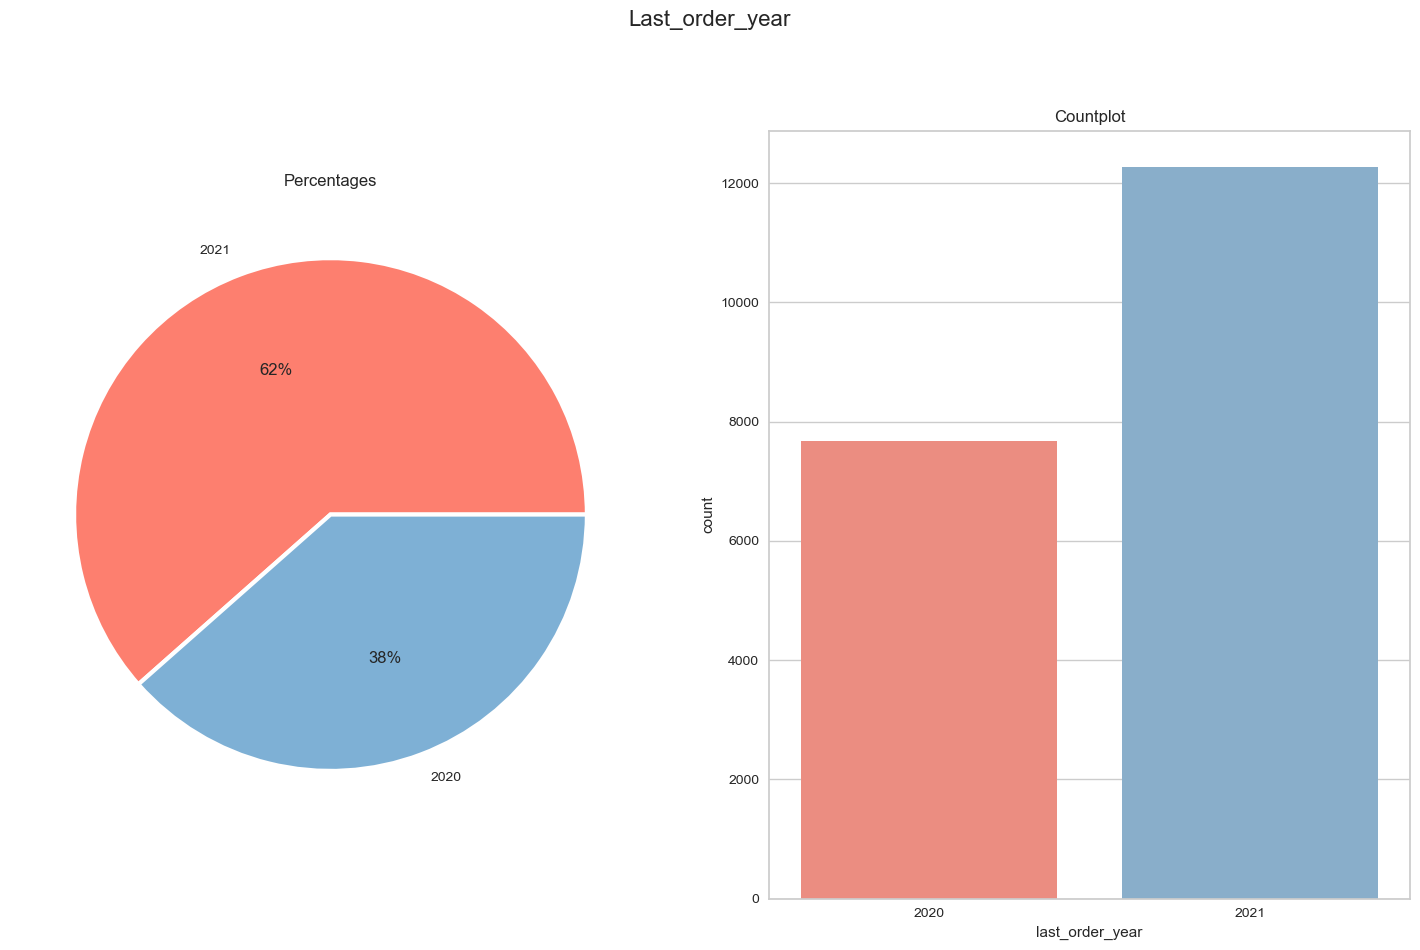

In [12]:
cat_plots(df, "last_order_year")

####################################################################################################
Saturday     3387
Sunday       3386
Monday       2680
Thursday     2655
Wednesday    2632
Friday       2631
Tuesday      2574
Name: first_order_day, dtype: int64


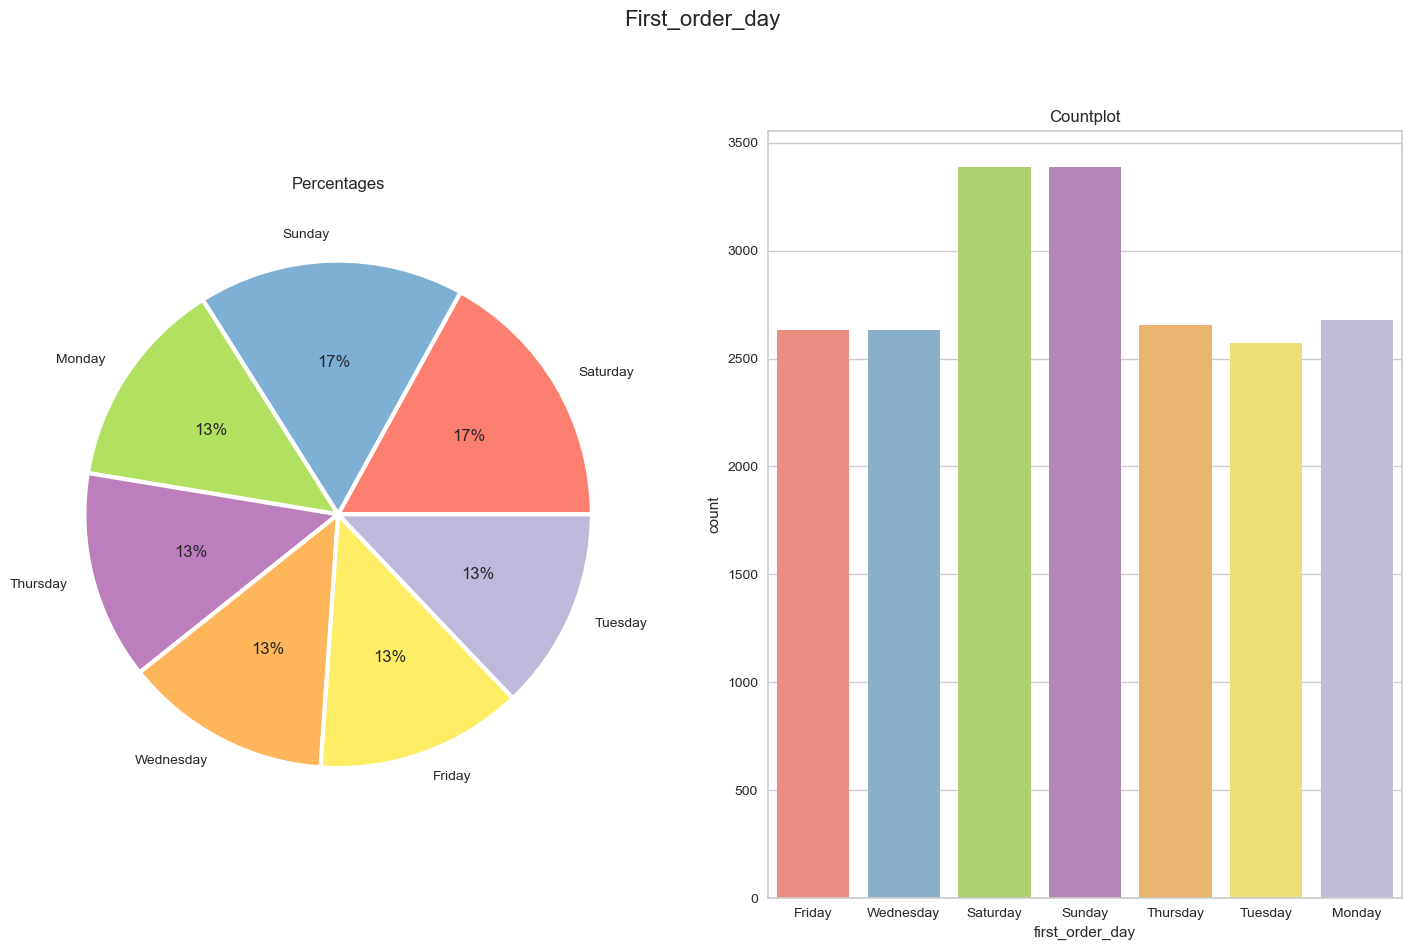

In [13]:
cat_plots(df, "first_order_day")

In [14]:
df["interested_in_categories_12"] = df["interested_in_categories_12"].apply(lambda x: x.replace("[", "").replace("]", "").split(","))
df["interested_in_categories_12"]

0                                    [KADIN]
1        [ERKEK,  COCUK,  KADIN,  AKTIFSPOR]
2                            [ERKEK,  KADIN]
3                       [AKTIFCOCUK,  COCUK]
4                                [AKTIFSPOR]
                        ...                 
19940                    [ERKEK,  AKTIFSPOR]
19941                            [AKTIFSPOR]
19942                            [AKTIFSPOR]
19943                    [ERKEK,  AKTIFSPOR]
19944                    [KADIN,  AKTIFSPOR]
Name: interested_in_categories_12, Length: 19945, dtype: object

In [15]:
cat = df["interested_in_categories_12"].explode()
cat.unique()

array(['KADIN', 'ERKEK', ' COCUK', ' KADIN', ' AKTIFSPOR', 'AKTIFCOCUK',
       'AKTIFSPOR', 'COCUK', ' ERKEK', ''], dtype=object)

In [16]:
cat = cat.apply(lambda x: x.strip(" "))
cat

0            KADIN
1            ERKEK
1            COCUK
1            KADIN
1        AKTIFSPOR
           ...    
19942    AKTIFSPOR
19943        ERKEK
19943    AKTIFSPOR
19944        KADIN
19944    AKTIFSPOR
Name: interested_in_categories_12, Length: 33178, dtype: object

In [17]:
pd.crosstab(cat.index, cat)

interested_in_categories_12,,AKTIFCOCUK,AKTIFSPOR,COCUK,ERKEK,KADIN
row_0,,,,,,
0,0,0,0,0,0,1
1,0,0,1,1,1,1
2,0,0,0,0,1,1
3,0,1,0,1,0,0
4,0,0,1,0,0,0
...,...,...,...,...,...,...
19940,0,0,1,0,1,0
19941,0,0,1,0,0,0
19942,0,0,1,0,0,0


In [18]:
categories = pd.crosstab(cat.index, cat).reset_index(drop=True).drop([""], axis=1)
categories

interested_in_categories_12,AKTIFCOCUK,AKTIFSPOR,COCUK,ERKEK,KADIN
0,0,0,0,0,1
1,0,1,1,1,1
2,0,0,0,1,1
3,1,0,1,0,0
4,0,1,0,0,0
...,...,...,...,...,...
19940,0,1,0,1,0
19941,0,1,0,0,0
19942,0,1,0,0,0
19943,0,1,0,1,0


In [19]:
df = df.join(categories)
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,new_total_expenditure,new_total_purchases,first_order_year,first_order_month,first_order_day,last_order_year,last_order_month,last_order_day,AKTIFCOCUK,AKTIFSPOR,COCUK,ERKEK,KADIN
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN],939.37,5.0,2020,October,Friday,2021,February,Friday,0,0,0,0,1
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",2013.55,21.0,2017,February,Wednesday,2021,February,Tuesday,0,1,1,1,1
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]",585.32,5.0,2019,November,Wednesday,2020,November,Friday,0,0,0,1,1
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]",121.97,2.0,2021,January,Wednesday,2021,January,Sunday,1,0,1,0,0
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR],209.98,2.0,2019,August,Saturday,2021,March,Sunday,0,1,0,0,0


####################################################################################################
0    16508
1     3437
Name: AKTIFCOCUK, dtype: int64


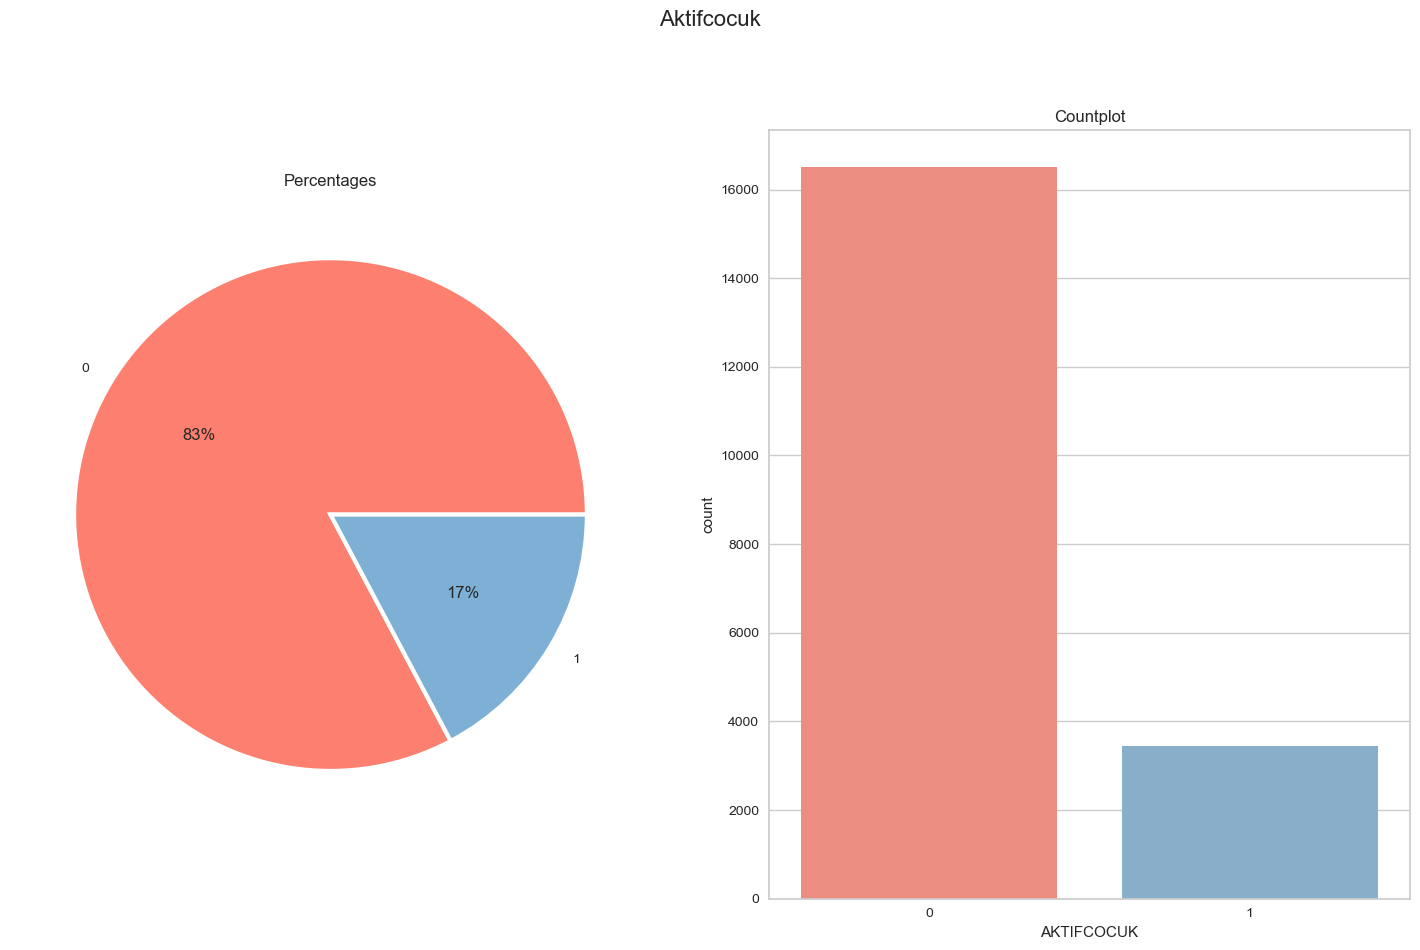

####################################################################################################
0    10741
1     9204
Name: AKTIFSPOR, dtype: int64


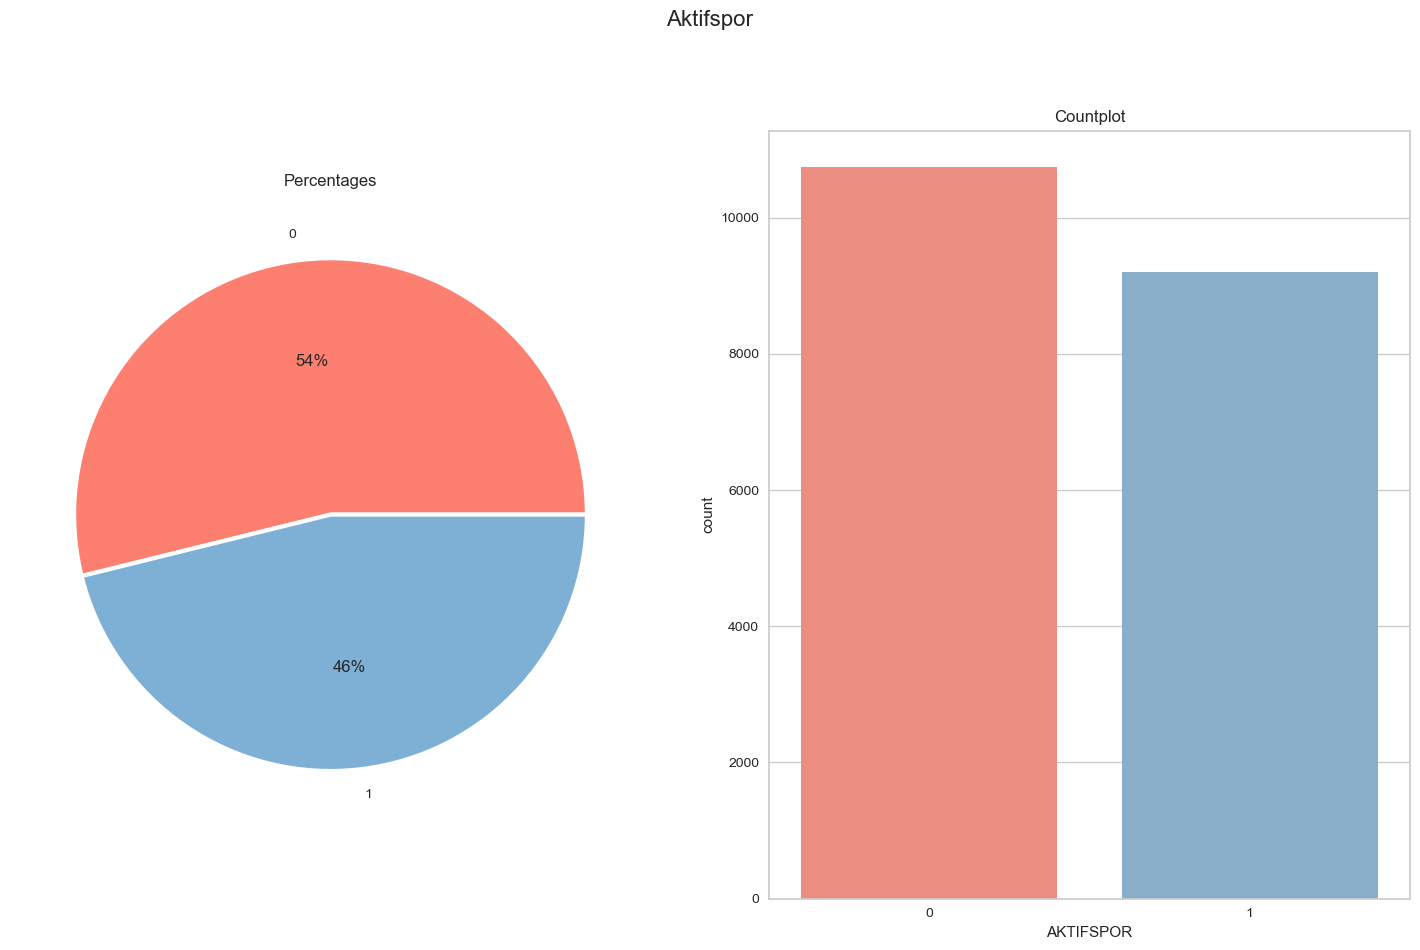

####################################################################################################
0    15788
1     4157
Name: COCUK, dtype: int64


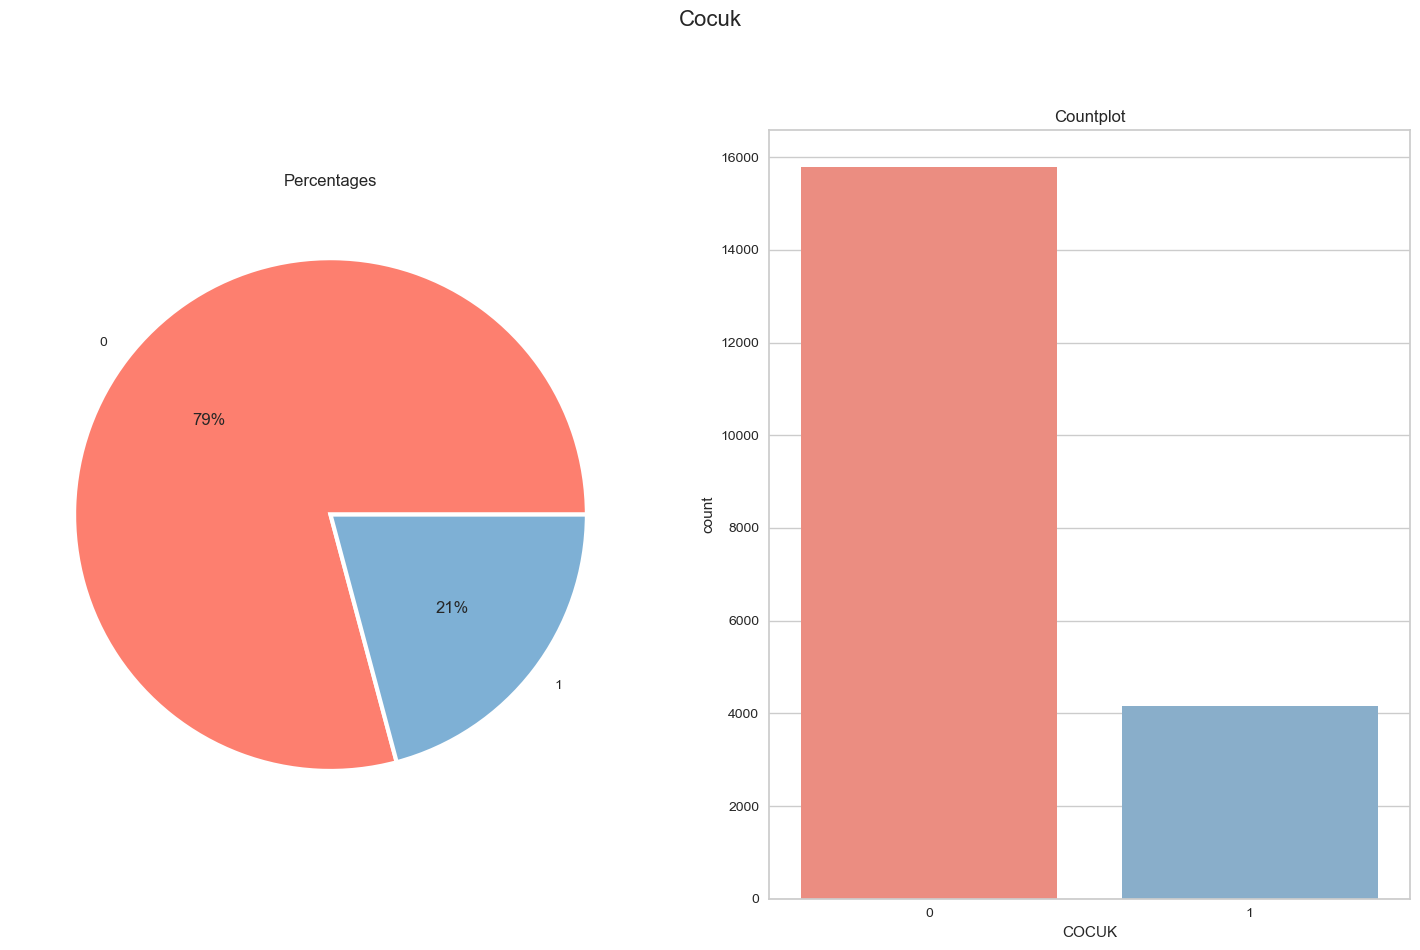

####################################################################################################
0    13303
1     6642
Name: ERKEK, dtype: int64


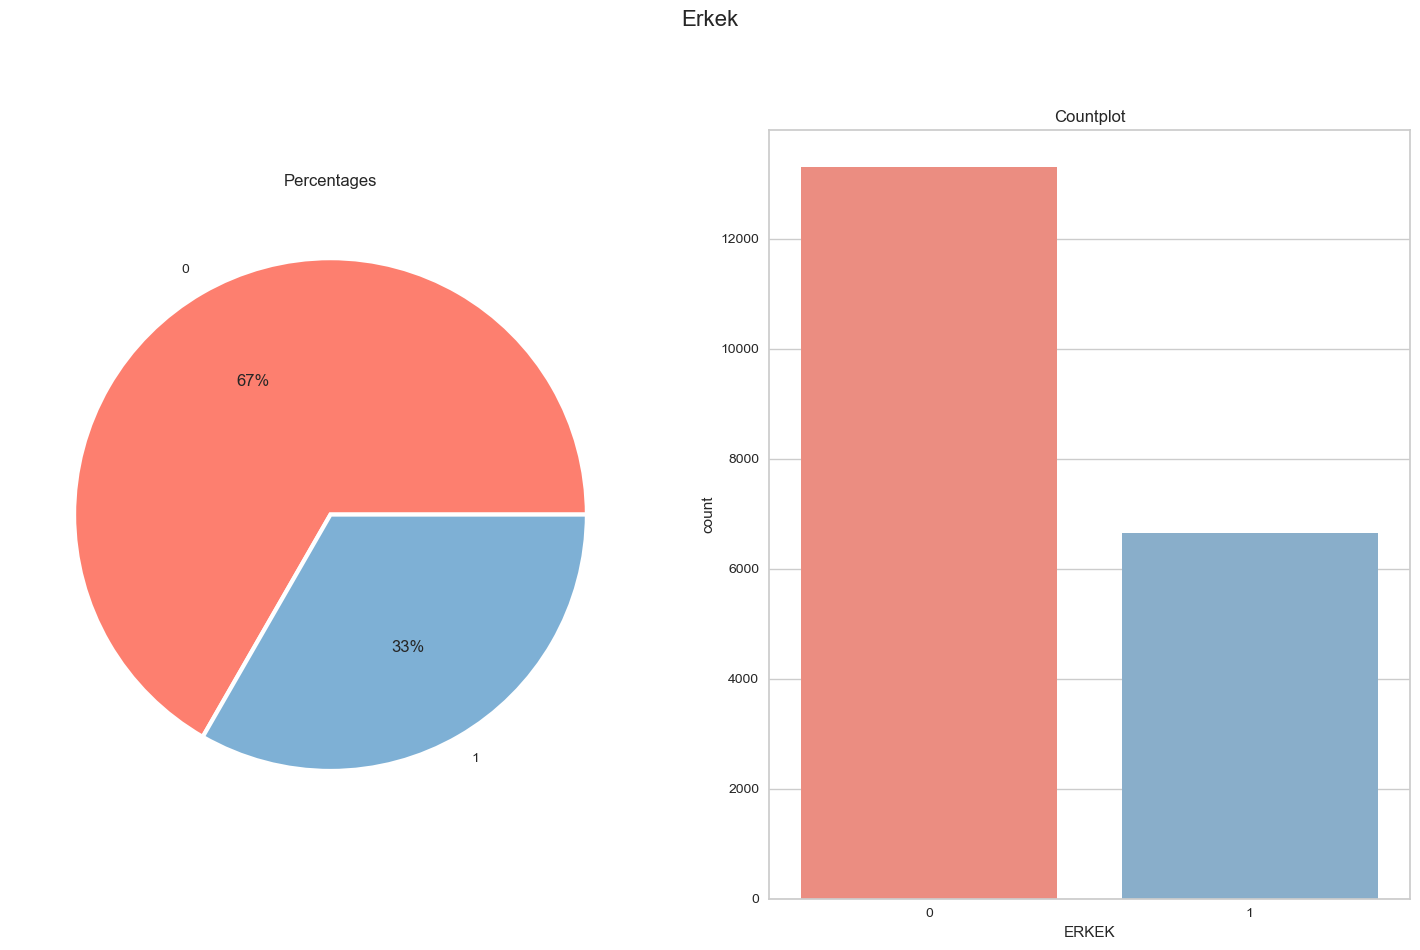

####################################################################################################
0    12342
1     7603
Name: KADIN, dtype: int64


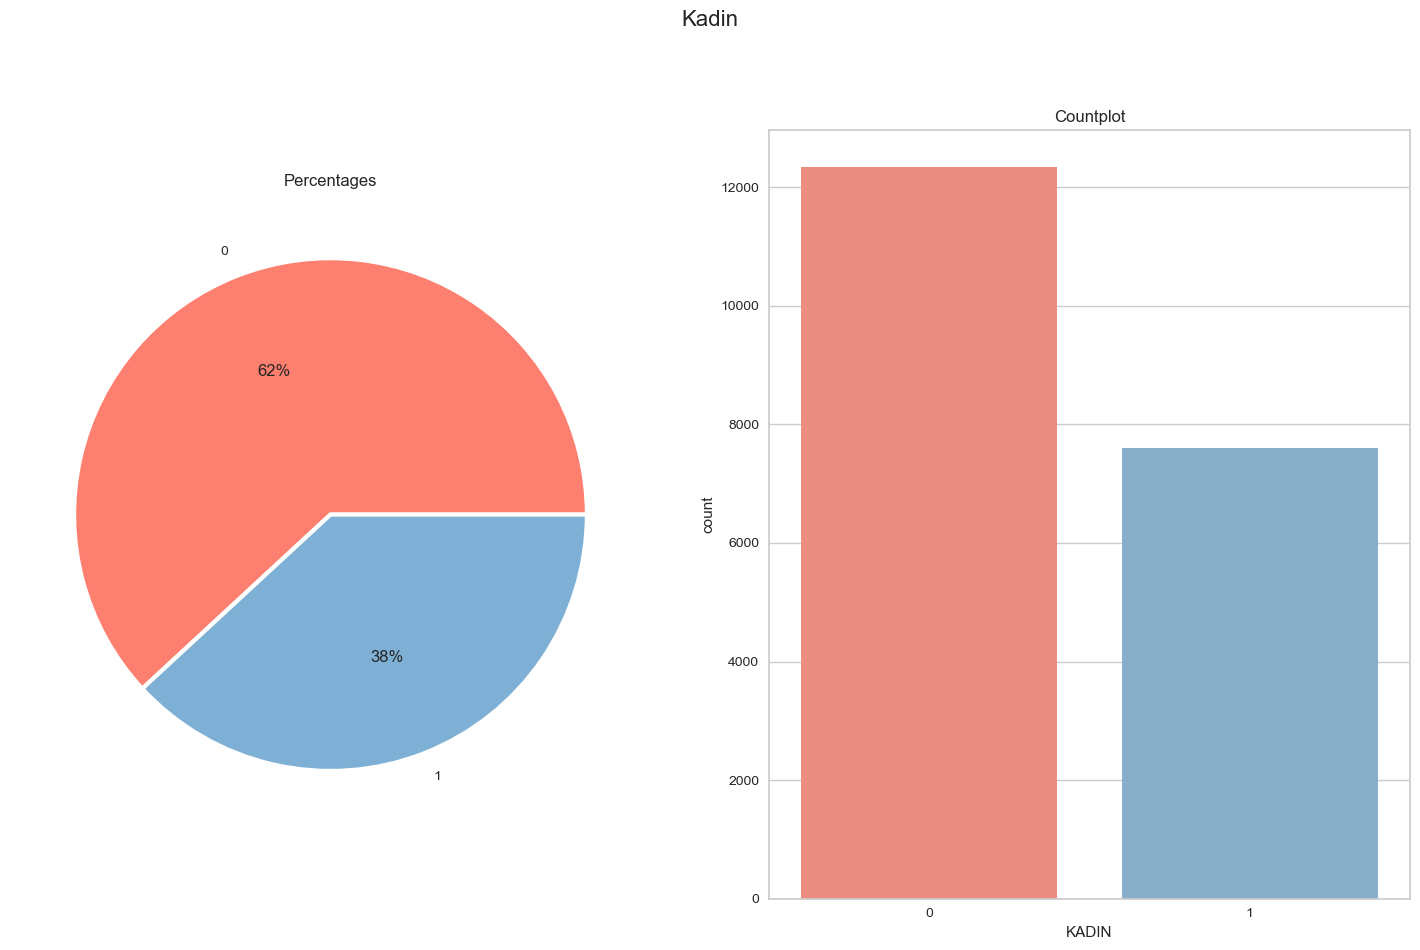

In [20]:
for col in df.columns[-5:].tolist():
    cat_plots(df, col)

In [21]:
today_date = df["last_order_date"].max() + dt.timedelta(days=2)
df["recency"] = (df["last_order_date"] - df["first_order_date"]).dt.days
df["average_expenditure"] = df["new_total_expenditure"] / df["new_total_purchases"]
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,new_total_expenditure,new_total_purchases,first_order_year,first_order_month,first_order_day,last_order_year,last_order_month,last_order_day,AKTIFCOCUK,AKTIFSPOR,COCUK,ERKEK,KADIN,recency,average_expenditure
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN],939.37,5.0,2020,October,Friday,2021,February,Friday,0,0,0,0,1,119,187.874000
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",2013.55,21.0,2017,February,Wednesday,2021,February,Tuesday,0,1,1,1,1,1469,95.883333
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]",585.32,5.0,2019,November,Wednesday,2020,November,Friday,0,0,0,1,1,366,117.064000
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]",121.97,2.0,2021,January,Wednesday,2021,January,Sunday,1,0,1,0,0,11,60.985000
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR],209.98,2.0,2019,August,Saturday,2021,March,Sunday,0,1,0,0,0,582,104.990000


In [22]:
df1 = df[["new_total_expenditure", "new_total_purchases", "recency", "average_expenditure"]]
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,new_total_expenditure,new_total_purchases,first_order_year,first_order_month,first_order_day,last_order_year,last_order_month,last_order_day,AKTIFCOCUK,AKTIFSPOR,COCUK,ERKEK,KADIN,recency,average_expenditure
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN],939.37,5.0,2020,October,Friday,2021,February,Friday,0,0,0,0,1,119,187.874000
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",2013.55,21.0,2017,February,Wednesday,2021,February,Tuesday,0,1,1,1,1,1469,95.883333
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]",585.32,5.0,2019,November,Wednesday,2020,November,Friday,0,0,0,1,1,366,117.064000
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]",121.97,2.0,2021,January,Wednesday,2021,January,Sunday,1,0,1,0,0,11,60.985000
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR],209.98,2.0,2019,August,Saturday,2021,March,Sunday,0,1,0,0,0,582,104.990000


In [23]:
df2 = df[["new_total_expenditure", "new_total_purchases", "recency", "average_expenditure",
          "order_channel", "AKTIFCOCUK", "AKTIFSPOR", "COCUK", "ERKEK", "KADIN"]]
df2.head()

,new_total_expenditure,new_total_purchases,recency,average_expenditure,order_channel,AKTIFCOCUK,AKTIFSPOR,COCUK,ERKEK,KADIN
0,939.37,5.0,119,187.874000,Android App,0,0,0,0,1
1,2013.55,21.0,1469,95.883333,Android App,0,1,1,1,1
2,585.32,5.0,366,117.064000,Android App,0,0,0,1,1
3,121.97,2.0,11,60.985000,Android App,1,0,1,0,0
4,209.98,2.0,582,104.990000,Desktop,0,1,0,0,0


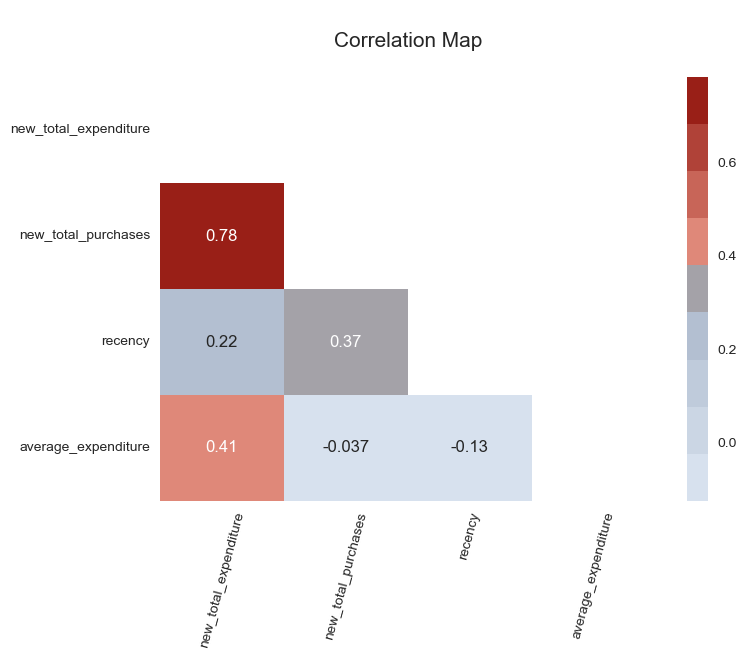

In [24]:
cm = ["#d7e1ee", "#cbd6e4", "#bfcbdb", "#b3bfd1", "#a4a2a8", "#df8879", "#c86558", "#b04238", "#991f17"]
corr = df1.corr()
corr_matrix = corr.abs()
msk = np.triu(corr)
sns.heatmap(corr, mask=msk, annot=True, linecolor="black", cmap=cm)
plt.yticks(rotation=0, size=10)
plt.xticks(rotation=75, size=10)
plt.title('\nCorrelation Map\n', size=15)
plt.show(block=True)

In [25]:
def outlier_threshold(dataframe, variable, q1=.01, q3=.99):
    quartile1 = dataframe[variable].quantile(q1)
    quartile3 = dataframe[variable].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_threshold(dataframe, variable)
    len_outlier = len(dataframe.loc[dataframe[variable] > up_limit]) + len(
        dataframe.loc[dataframe[variable] < low_limit])
    print(f"{variable} variable have {len_outlier} outliers")
    dataframe[variable] = dataframe[variable].apply(
        lambda x: round(up_limit) if x > up_limit else (round(low_limit) if x < low_limit else x))
    
for col in df1.columns:
    replace_with_thresholds(df1, col)
    replace_with_thresholds(df2, col)

new_total_expenditure variable have 13 outliers
new_total_expenditure variable have 13 outliers
new_total_purchases variable have 17 outliers
new_total_purchases variable have 17 outliers
recency variable have 0 outliers
recency variable have 0 outliers
average_expenditure variable have 4 outliers
average_expenditure variable have 4 outliers


C:\Users\suley\AppData\Local\Temp\ipykernel_17076\3184501006.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[variable] = dataframe[variable].apply(


In [26]:
scaler = MinMaxScaler((0, 1))
df1 = pd.DataFrame(scaler.fit_transform(df1), columns=df1.columns)
df1.head()

,new_total_expenditure,new_total_purchases,recency,average_expenditure
0,0.101635,0.06,0.039222,0.180647
1,0.223701,0.38,0.484179,0.080167
2,0.061402,0.06,0.120633,0.103302
3,0.008749,0.00,0.003626,0.042048
4,0.018750,0.00,0.191826,0.090114


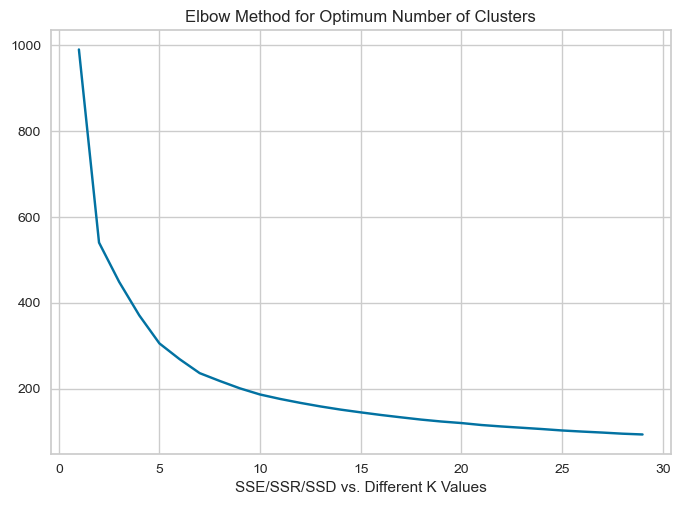

In [27]:
kmeans = KMeans()
ssd = []
K = range(1, 30)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(df1)
    ssd.append(kmeans.inertia_)

plt.plot(K, ssd, "bx-")
plt.xlabel("SSE/SSR/SSD vs. Different K Values")
plt.title("Elbow Method for Optimum Number of Clusters")
plt.show(block=True)

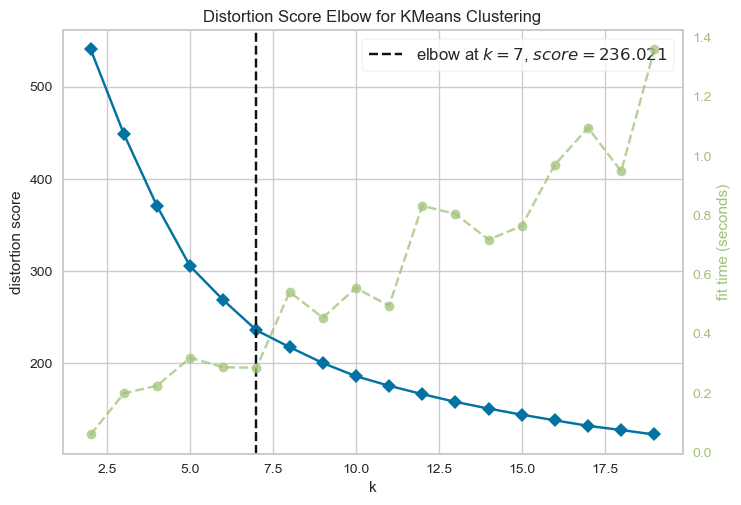

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(df1)
elbow.show()

In [29]:
opt_kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(df1)
df1["kmeans_cluster"] = opt_kmeans.labels_
df1.head()

,new_total_expenditure,new_total_purchases,recency,average_expenditure,kmeans_cluster
0,0.101635,0.06,0.039222,0.180647,4
1,0.223701,0.38,0.484179,0.080167,5
2,0.061402,0.06,0.120633,0.103302,4
3,0.008749,0.00,0.003626,0.042048,4
4,0.018750,0.00,0.191826,0.090114,0


####################################################################################################
0    7203
4    5418
6    2362
1    1827
2    1618
3    1197
5     320
Name: kmeans_cluster, dtype: int64


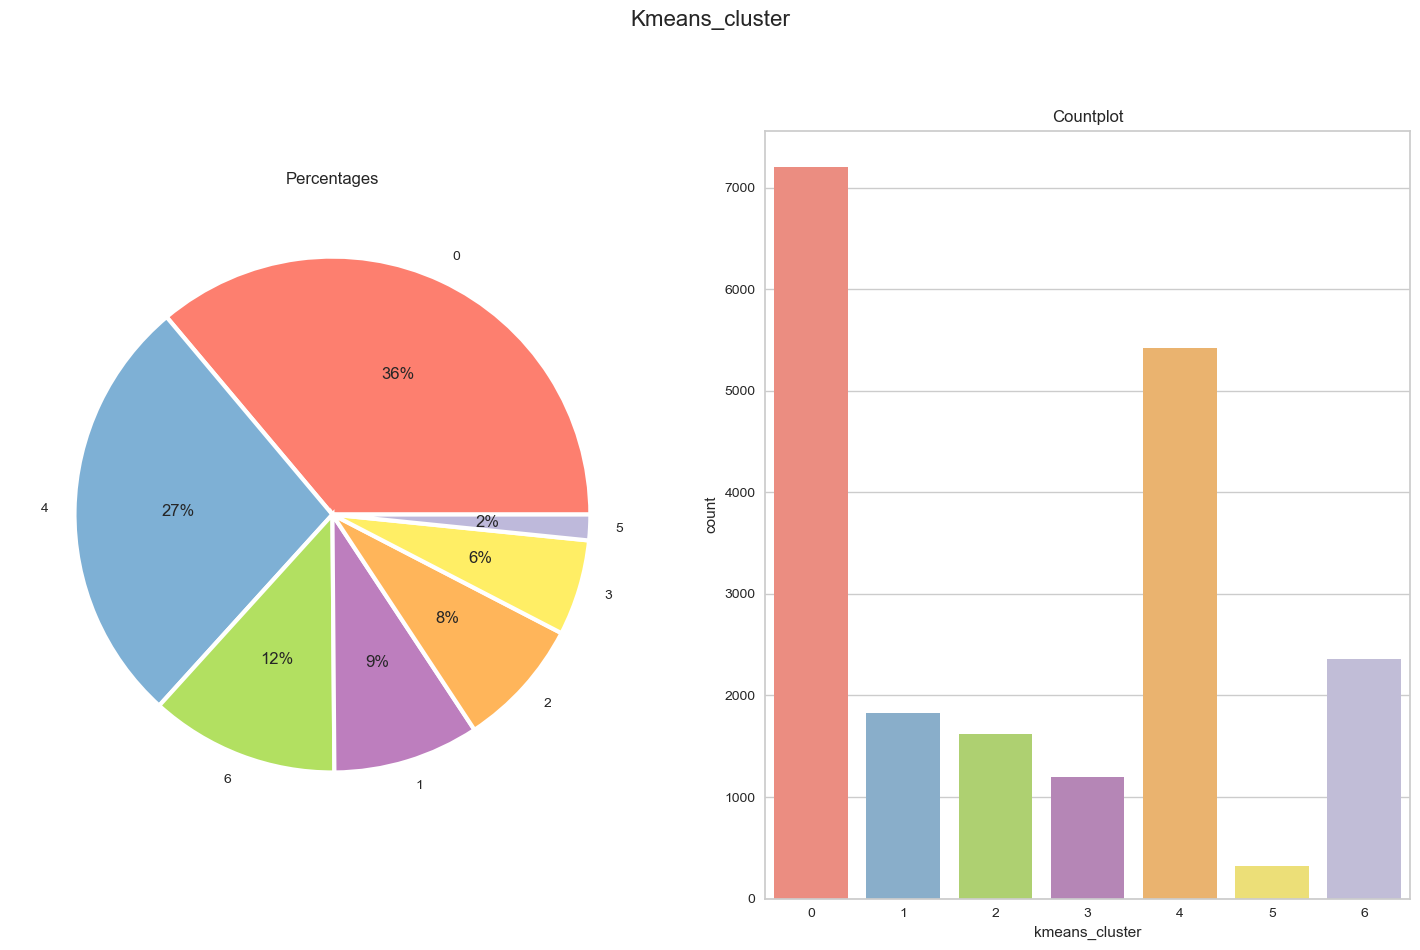

In [30]:
cat_plots(df1, "kmeans_cluster")

In [31]:
scaler = MinMaxScaler((0, 1))
df2 = pd.get_dummies(df2, drop_first=True)
df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns)
df2.head()

,new_total_expenditure,new_total_purchases,recency,average_expenditure,AKTIFCOCUK,AKTIFSPOR,COCUK,ERKEK,KADIN,order_channel_Desktop,order_channel_Ios App,order_channel_Mobile
0,0.101635,0.06,0.039222,0.180647,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.223701,0.38,0.484179,0.080167,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2,0.061402,0.06,0.120633,0.103302,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.008749,0.00,0.003626,0.042048,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.018750,0.00,0.191826,0.090114,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


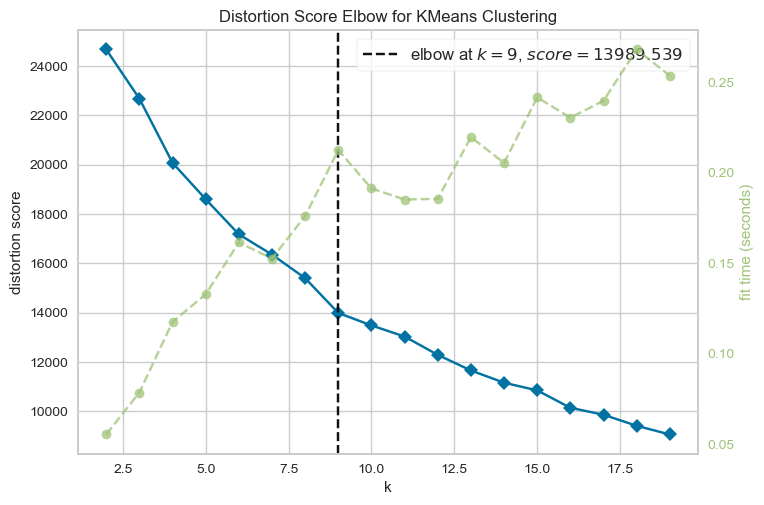

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [32]:
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(df2)
elbow.show()

In [33]:
opt_kmeans2 = KMeans(n_clusters=elbow.elbow_value_).fit(df2)
df2["kmeans_cluster"] = opt_kmeans2.labels_
df2.head()

,new_total_expenditure,new_total_purchases,recency,average_expenditure,AKTIFCOCUK,AKTIFSPOR,COCUK,ERKEK,KADIN,order_channel_Desktop,order_channel_Ios App,order_channel_Mobile,kmeans_cluster
0,0.101635,0.06,0.039222,0.180647,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
1,0.223701,0.38,0.484179,0.080167,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,3
2,0.061402,0.06,0.120633,0.103302,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,6
3,0.008749,0.00,0.003626,0.042048,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8
4,0.018750,0.00,0.191826,0.090114,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,5


####################################################################################################
5    3100
6    2915
4    2551
2    2445
1    2237
3    2056
8    1900
0    1765
7     976
Name: kmeans_cluster, dtype: int64


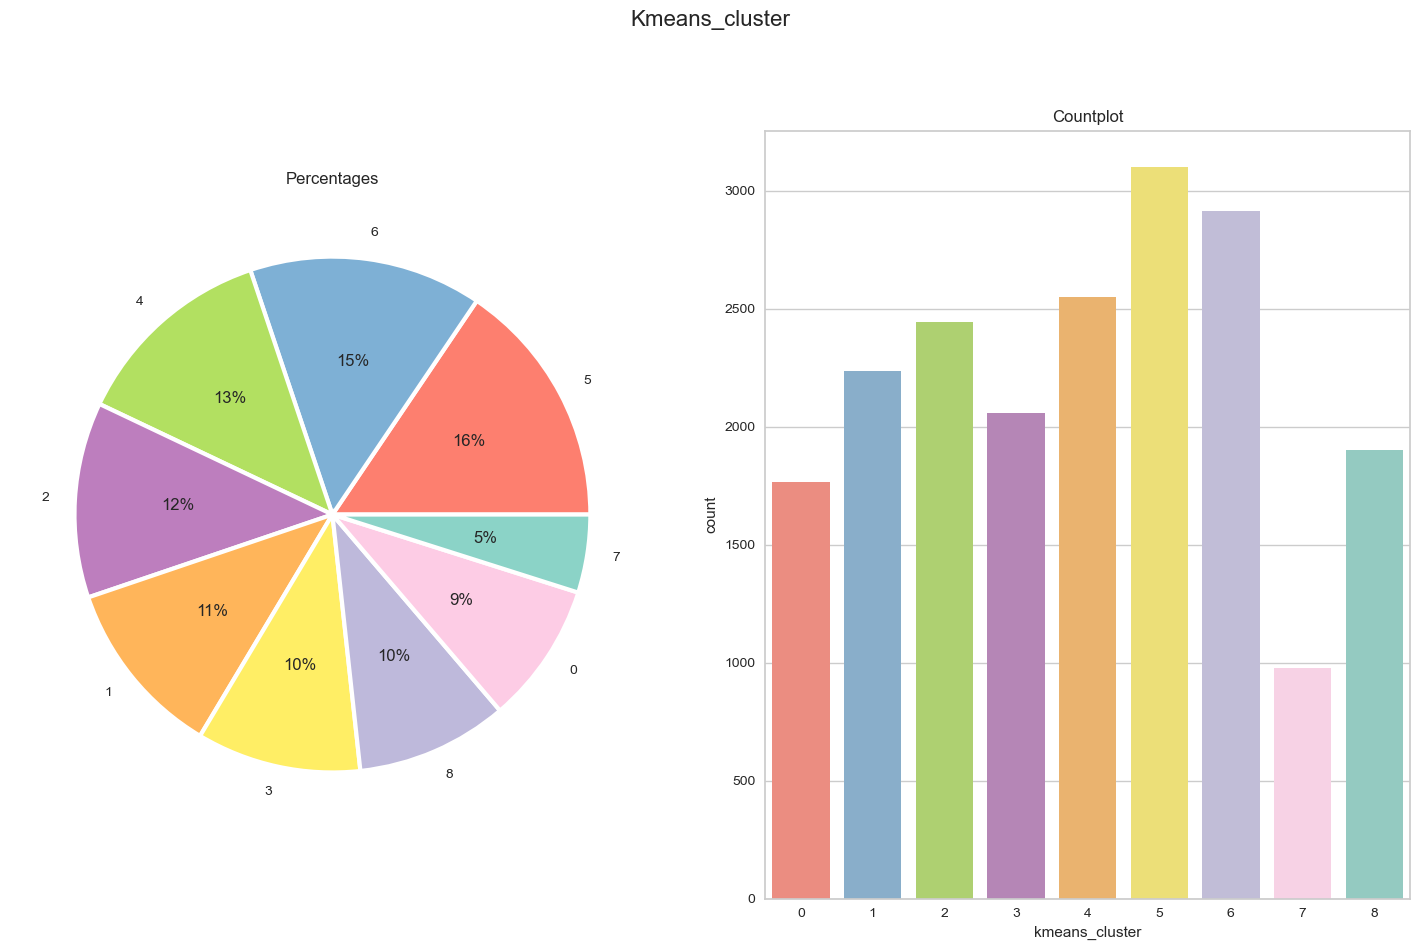

In [34]:
cat_plots(df2, "kmeans_cluster")

In [35]:
df1.groupby("kmeans_cluster").agg(["mean", "median", "count"])

new_total_expenditure                 new_total_purchases                recency                 average_expenditure                
                                mean    median count                mean median count      mean    median count                mean    median count
kmeans_cluster                                                                                                                                     
0                           0.053376  0.048970  7203            0.041666   0.04  7203  0.202570  0.195452  7203            0.114707  0.111072  7203
1                           0.084936  0.074924  1827            0.081489   0.06  1827  0.427949  0.421556  1827            0.122060  0.111450  1827
2                           0.191692  0.168342  1618            0.171125   0.16  1618  0.224861  0.221819  1618            0.160257  0.152505  1618
3                           0.096484  0.079982  1197            0.100769   0.08  1197  0.710159  0.701714  1197            0.116949  0.105404  1197
4                           0.040749  0.035810  5418            0.022130   0.02  5418  0.083538  0.091628  5418            0.118515  0.115671  5418
5                           0.436009  0.378660   320            0.493500   0.44   320  0.531914  0.510053   320            0.145298  0.126368   320
6                           0.108947  0.094798  2362            0.030415   0.02  2362  0.129569  0.133817  2362            0.290422  0.263554  2362

In [36]:
df2.groupby("kmeans_cluster").agg(["mean", "median", "count"])

new_total_expenditure                 new_total_purchases                recency                 average_expenditure                 AKTIFCOCUK              AKTIFSPOR                  COCUK                  ERKEK                  KADIN              order_channel_Desktop              order_channel_Ios App              order_channel_Mobile             
                                mean    median count                mean median count      mean    median count                mean    median count       mean median count      mean median count      mean median count      mean median count      mean median count                  mean median count                  mean median count                 mean median count
kmeans_cluster                                                                                                                                                                                                                                                                                                                                                                 
0                           0.070062  0.052265  1765            0.057790   0.04  1765  0.228495  0.179301  1765            0.129512  0.114415  1765   0.081020    0.0  1765  0.363739    0.0  1765  0.132578    0.0  1765  0.247592    0.0  1765  1.000000    1.0  1765              0.000000    0.0  1765              0.000000    0.0  1765             1.000000    1.0  1765
1                           0.081392  0.059483  2237            0.063567   0.04  2237  0.186471  0.159525  2237            0.137549  0.122342  2237   0.110863    0.0  2237  0.438981    0.0  2237  0.045597    0.0  2237  0.000000    0.0  2237  1.000000    1.0  2237              0.000000    0.0  2237              0.278945    0.0  2237             0.000000    0.0  2237
2                           0.060324  0.046692  2445            0.039517   0.02  2445  0.224354  0.182927  2445            0.139257  0.122055  2445   0.165235    0.0  2445  0.521063    1.0  2445  0.191411    0.0  2445  0.101840    0.0  2445  0.000000    0.0  2445              0.000000    0.0  2445              0.000000    0.0  2445             1.000000    1.0  2445
3                           0.125104  0.091512  2056            0.100914   0.06  2056  0.204931  0.167436  2056            0.162224  0.145658  2056   0.104086    0.0  2056  1.000000    1.0  2056  0.150292    0.0  2056  1.000000    1.0  2056  0.403210    0.0  2056              0.073444    0.0  2056              0.211576    0.0  2056             0.000486    0.0  2056
4                           0.054527  0.042326  2551            0.037107   0.02  2551  0.234531  0.192156  2551            0.127186  0.110310  2551   0.184633    0.0  2551  0.000000    0.0  2551  0.218346    0.0  2551  0.000000    0.0  2551  0.000000    0.0  2551              0.218346    0.0  2551              0.175225    0.0  2551             0.000000    0.0  2551
5                           0.078872  0.060351  3100            0.048361   0.04  3100  0.205268  0.164469  3100            0.164831  0.146063  3100   0.079677    0.0  3100  1.000000    1.0  3100  0.080323    0.0  3100  0.000000    0.0  3100  0.000000    0.0  3100              0.182903    0.0  3100              0.199032    0.0  3100             0.000000    0.0  3100
6                           0.067460  0.049767  2915            0.051506   0.04  2915  0.206742  0.168095  2915            0.129500  0.118713  2915   0.073413    0.0  2915  0.000000    0.0  2915  0.073756    0.0  2915  1.000000    1.0  2915  0.197256    0.0  2915              0.114580    0.0  2915              0.163979    0.0  2915             0.172213    0.0  2915
7                           0.067037  0.049536   976            0.045799   0.02   976  0.319571  0.233850   976            0.139312  0.120323   976   0.064549    0.0   976  0.323770    0.0   976  0.126025    0.0   976  0.293033    0.0   976  1.000000    1.0   976              1.000000    1.0   976              0.000000    0.0   976  

In [37]:
df = df1
df.head()

,new_total_expenditure,new_total_purchases,recency,average_expenditure,kmeans_cluster
0,0.101635,0.06,0.039222,0.180647,4
1,0.223701,0.38,0.484179,0.080167,5
2,0.061402,0.06,0.120633,0.103302,4
3,0.008749,0.00,0.003626,0.042048,4
4,0.018750,0.00,0.191826,0.090114,0


In [38]:
num_cols = df.columns[:-1]
num_cols

Index(['new_total_expenditure', 'new_total_purchases', 'recency', 'average_expenditure'], dtype='object')

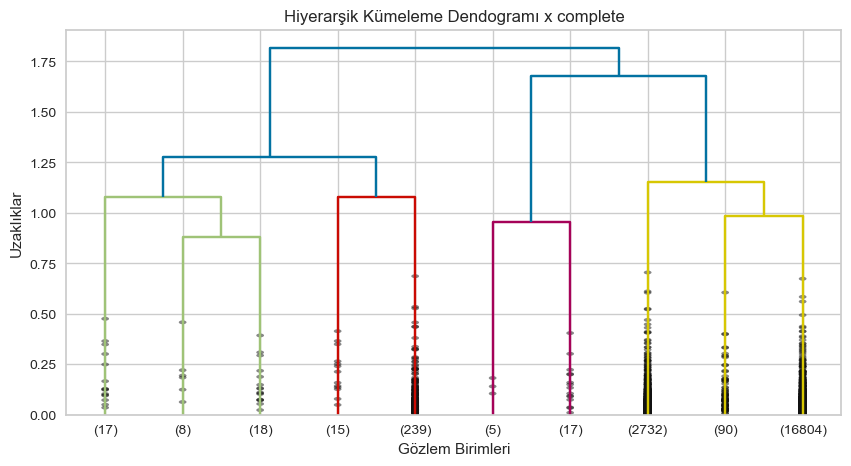

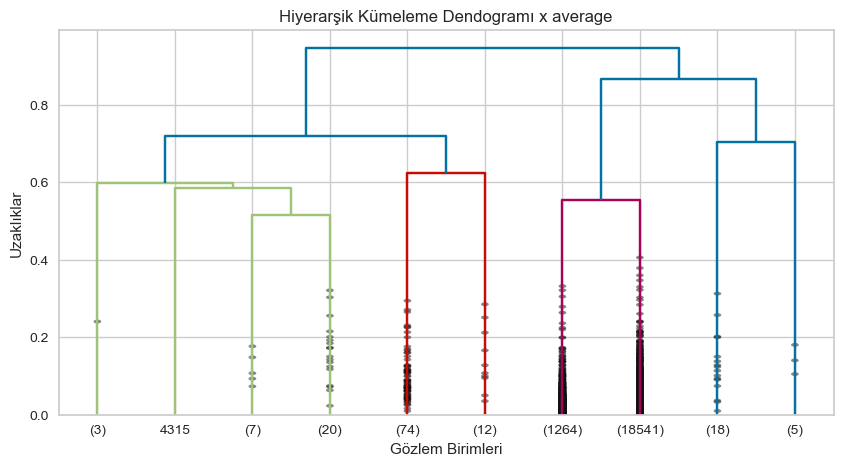

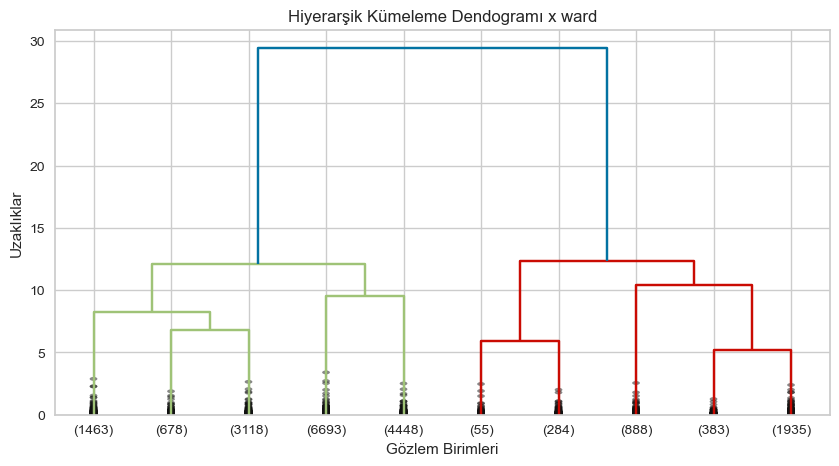

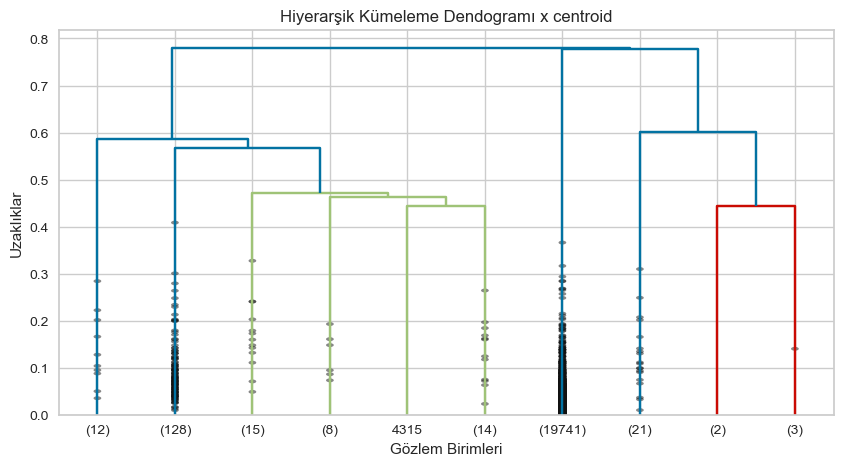

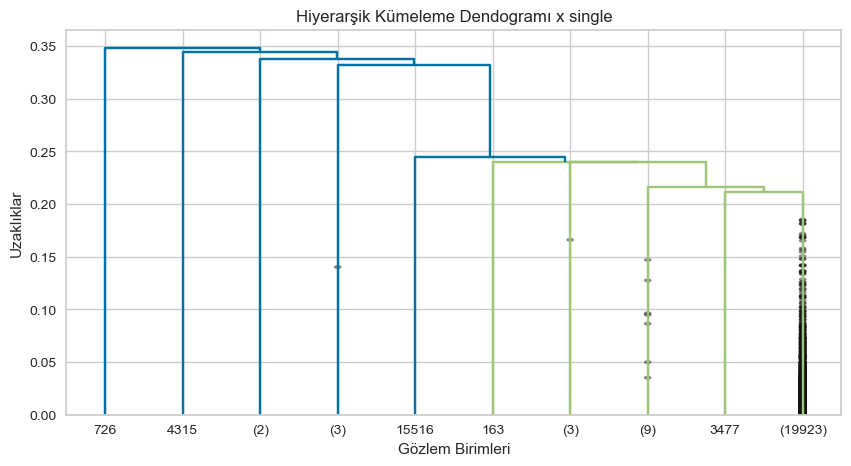

In [39]:
methods = ["complete", "average", "ward", "centroid", "single"]
for method in methods:
    hc = linkage(df[num_cols], method)
    plt.figure(figsize=(10, 5))
    plt.title(f"Hiyerarşik Kümeleme Dendogramı x {method}")
    plt.xlabel("Gözlem Birimleri")
    plt.ylabel("Uzaklıklar")
    dendrogram(hc,
               truncate_mode="lastp",
               p=10,
               show_contracted=True,
               leaf_font_size=10)
    plt.show()

In [40]:
cluster = AgglomerativeClustering(n_clusters=7, linkage="ward")
clusters = cluster.fit_predict(df[num_cols])
df["hc_clusters"] = clusters

In [41]:
df = pd.read_csv("flo_data_20k.csv")
date_vars = df.columns[df.columns.str.contains("date")]

for col in date_vars:
    df[col] = pd.to_datetime(df[col])
    
df["new_total_expenditure"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]
df["new_total_purchases"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
today_date = df["last_order_date"].max() + dt.timedelta(days=2)
df["recency"] = (df["last_order_date"] - df["first_order_date"]).dt.days
df["average_expenditure"] = df["new_total_expenditure"] / df["new_total_purchases"]
df = df[["new_total_expenditure", "new_total_purchases", "recency", "average_expenditure"]]
df["kmeans_clusters"] = opt_kmeans.labels_
df["hc_clusters"] = clusters

In [42]:
df.head()

,new_total_expenditure,new_total_purchases,recency,average_expenditure,kmeans_clusters,hc_clusters
0,939.37,5.0,119,187.874000,4,3
1,2013.55,21.0,1469,95.883333,5,1
2,585.32,5.0,366,117.064000,4,0
3,121.97,2.0,11,60.985000,4,3
4,209.98,2.0,582,104.990000,0,5


In [43]:
df.groupby("kmeans_clusters").agg(["mean", "median", "count"])

new_total_expenditure                 new_total_purchases                   recency               average_expenditure                   hc_clusters             
                                 mean    median count                mean median count         mean  median count                mean      median count        mean median count
kmeans_clusters                                                                                                                                                                 
0                          514.692232   475.920  7203            4.083299    4.0  7203   614.597806   593.0  7203          127.505297  124.177500  7203    4.167986    5.0  7203
1                          792.416136   704.310  1827            6.074439    5.0  1827  1298.397373  1279.0  1827          134.237209  124.523333  1827    1.133005    1.0  1827
2                         1731.875433  1526.395  1618           10.556242   10.0  1618   682.228677   673.0  1618          169.206490  162.109500  1618    4.529048    6.0  1618
3                          894.042623   748.820  1197            7.038429    6.0  1197  2154.621554  2129.0  1197          129.557843  118.988000  1197    3.277360    4.0  1197
4                          403.572735   360.105  5418            3.106497    3.0  5418   253.452935   278.0  5418          130.991923  128.387500  5418    3.035991    3.0  5418
5                         4264.299250  3377.195   320           28.303125   24.0   320  1613.828125  1547.5   320          155.511991  138.181341   320    2.306250    2.0   320
6                         1018.212773   879.205  2362            3.520745    3.0  2362   393.112616   406.0  2362          291.109230  263.776000  2362    0.679509    0.0  2362

In [44]:
df.groupby("hc_clusters").agg(["mean", "median", "count"])

new_total_expenditure                 new_total_purchases                   recency               average_expenditure                   kmeans_clusters             
                             mean    median count                mean median count         mean  median count                mean      median count            mean median count
hc_clusters                                                                                                                                                                     
0                      989.379062   888.875  3796            4.643572    5.0  3796   456.047155   456.0  3796          231.567611  212.919167  3796        3.663593    4.0  3796
1                      834.501488   680.550  2318            6.385677    5.0  2318  1323.700173  1286.0  2318          132.240285  123.883750  2318        1.239862    1.0  2318
2                     4044.303068  3069.650   339           26.533923   22.0   339  1889.539823  2019.0   339          172.767771  131.978421   339        4.483776    5.0   339
3                      407.550245   380.895  4448            2.842401    3.0  4448   209.405351   219.5  4448          146.802481  138.464167  4448        4.186151    4.0  4448
4                      832.532196   748.785   888            6.618243    6.0   888  2205.015766  2166.0   888          129.528740  114.458917   888        2.988739    3.0   888
5                      427.049601   392.910  6693            3.722695    3.0  6693   589.459286   576.0  6693          117.163531  112.235000  6693        0.585238    0.0  6693
6                     1717.140219  1441.140  1463           10.498291    9.0  1463   700.907040   710.0  1463          166.302511  154.971429  1463        1.781271    2.0  1463

In [45]:
df.groupby(["hc_clusters", "kmeans_clusters"]).agg(["mean", "median", "count"])

new_total_expenditure                  new_total_purchases                   recency               average_expenditure                   
                                             mean     median count                mean median count         mean  median count                mean       median count
hc_clusters kmeans_clusters                                                                                                                                          
0           0                          810.692783    810.420  1103            4.947416    5.0  1103   539.647325   534.0  1103          170.374898   172.521667  1103
            1                         1359.310000   1359.310     1            5.000000    5.0     1  1011.000000  1011.0     1          271.862000   271.862000     1
            2                         1519.435782   1468.835   294            8.057823    8.0   294   500.880952   476.5   294          193.700700   197.871429   294
            4                          808.669850    769.950   535            5.413084    5.0   535   330.981308   350.0   535          154.675808   158.820000   535
            6                         1063.218991    961.940  1863            3.703704    3.0  1863   435.093398   443.0  1863          295.832375   272.485000  1863
1           0                          455.076316    480.870   171            3.994152    4.0   171   923.923977   931.0   171          114.088655   111.788000   171
            1                          785.174980    690.450  1767            6.054895    5.0  1767  1306.362762  1288.0  1767          133.139430   123.432500  1767
            2                         1819.945714   1701.030   112           13.107143   13.0   112  1088.830357  1064.5   112          142.540541   136.979545   112
            3                          712.159083    610.910   229            5.585153    5.0   229  1840.393013  1826.0   229          129.344960   124.290000   229
            5                         2665.070000   2681.125    38           17.631579   18.0    38  1514.842105  1464.5    38          154.250328   150.586029    38
            6                          961.200000    961.200     1            3.000000    3.0     1  1040.000000  1040.0     1          320.400000   320.400000     1
2           3                         2090.303258   2050.500    89           15.370787   15.0    89  2421.314607  2349.0    89          138.824259   132.907647    89
            5                         4555.881498   3561.000   247           30.789474   25.0   247  1719.157895  1715.0   247          150.166024   130.384754   247
            6                        19893.006667  20706.340     3            7.333333    7.0     3   141.666667    43.0     3         3040.635866  2838.855455     3
3           0                          473.042353    459.860    17            4.235294    4.0    17   433.764706   436.0    17          112.927206   112.990000    17
            4                          378.170349    359.970  3983            2.859151    3.0  3983   210.753201   222.0  3983          135.014132   131.740000  3983
            6                          666.270692    589.380   448            2.640625    2.0   448   188.908482   192.0   448          252.893716   247.945000   448
4           1                         1299.414286   1078.990     7           10.285714   11.0     7  1642.285714  1648.0     7          176.588742    99.987273     7
            3                          820.304437    737.180   879            6.573379    6.0   879  2209.482366  2168.0   879          128.675067   114.155833   879
            5                         4572.545000   4572.545     2           13.500000   13.5     2  2211.500000  2211.5     2          340.008049   340.008049     2
5           0                          440.672324    413.970  5672            3.802010    3.0  5672   615.918195   600.0  5672          119.058271   115.064583  5672
            1                          861.1